### Read in data

In [ ]:
import pandas as pd
padmapper_path = "PadmapperData/Padmapper2025.xlsx"
df = pd.read_excel(padmapper_path)

In [2]:
import numpy as np

# Divide Price by number of Beds since in padmapper it is standardized
df["StdPrice"] = np.where(
    df["Bed"] > 0,
    df["Price"] / df["Bed"],
    df["Price"]  # for studios, just use total SqFt since we can't divide by 0
)

### Rent vs Square Feet

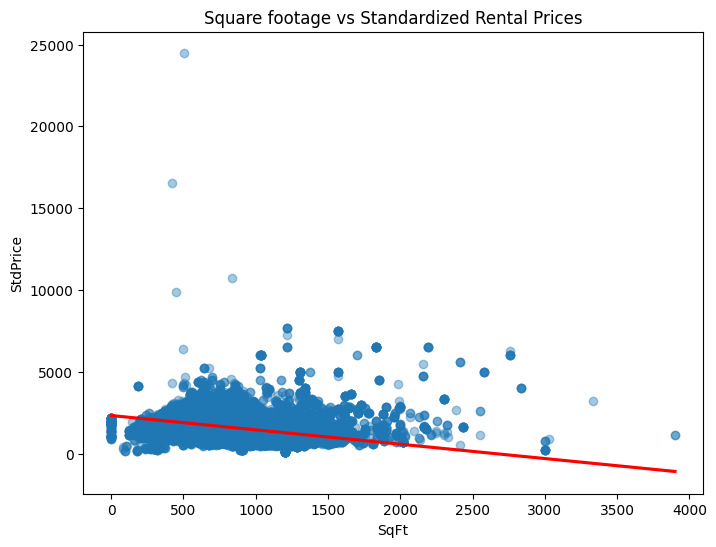

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.regplot(data=df, x="SqFt", y="StdPrice", scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title("Square footage vs Standardized Rental Prices")
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.regplot(data=df, x="SqFt", y="Price", scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title("Square footage vs Rental Prices")
plt.show()

In [4]:
from scipy import stats

# Standardized SqFt
slope, intercept, r_value, p_value, std_err = stats.linregress(df["SqFt"], df["StdPrice"])
print("\nSqFt → Standardized Rent")
print(f"Line: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}, p = {p_value:.4e}")



SqFt → Standardized Rent
Line: y = -0.88x + 2324.96
R² = 0.1211, p = 0.0000e+00


### Examining Amenities
Padmapper doesn't have parking in the data, will likely use entrata data for that

In [5]:
# Amenity Columns
amenity_cols = [
    "Fitness Center", "Swimming Pool", "In Unit Laundry"
]

# Calculate average rent for units with vs. without each amenity
amenity_summary = {}
for col in amenity_cols:
    amenity_summary[col] = df.groupby(col)["Price"].mean()

amenity_df = pd.DataFrame(amenity_summary).T
amenity_df.columns = ["No Amenity Avg Rent", "Amenity Avg Rent"]
amenity_df

,No Amenity Avg Rent,Amenity Avg Rent
Fitness Center,2135.057962,2478.897002
Swimming Pool,2194.653326,2571.099862
In Unit Laundry,2111.528633,2483.900806


### Run T-test to calculate if difference in means is statistically significant

In [6]:
t_test_results = []

for col in amenity_cols:
    group0 = df.loc[df[col] == 0, "Price"]
    group1 = df.loc[df[col] == 1, "Price"]
    
    # t-test (does not assume equal variance)
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False, nan_policy="omit")
    
    t_test_results.append({
        "Amenity": col,
        "Mean Rent (No)": group0.mean(),
        "Mean Rent (Yes)": group1.mean(),
        "Difference": group1.mean() - group0.mean(),
        "t-statistic": t_stat,
        "p-value": p_val
    })

t_test_df = pd.DataFrame(t_test_results).set_index("Amenity")
t_test_df


,Mean Rent (No),Mean Rent (Yes),Difference,t-statistic,p-value
Amenity,,,,,
Fitness Center,2135.057962,2478.897002,343.839040,-71.148916,0.0
Swimming Pool,2194.653326,2571.099862,376.446536,-68.590567,0.0
In Unit Laundry,2111.528633,2483.900806,372.372174,-78.738453,0.0


From above, it seems that fitness center (gym), pool, and laundry yielded higher average rental income than their counterparts which do not have these

### Examining Building Age

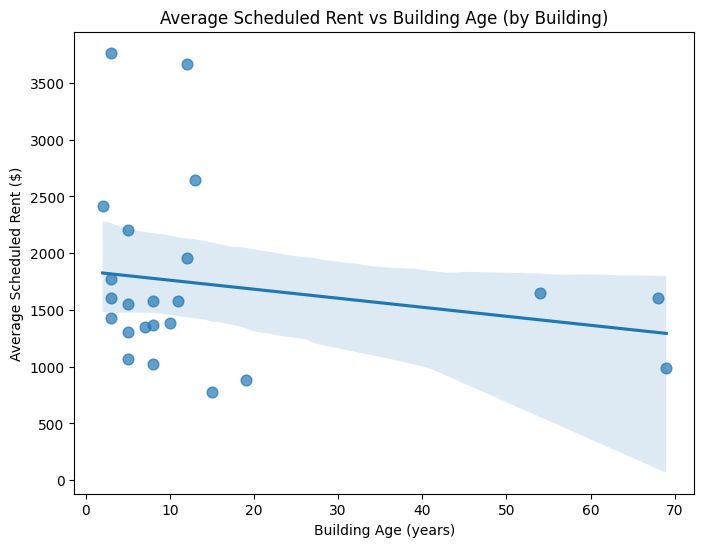

(                      Building  Age      AvgRent
 0                    17Hundred   15   779.145900
 1                      1Eleven   10  1385.081838
 2                1Ten_on_Whyte   69   988.629479
 3                     308_King    2  2418.006011
 4                    417Nelson    7  1350.840376
 5         ALMA_@_ByWard_Market    3  1777.134988
 6                ALMA_@_Guelph    3  1607.602552
 7                ALMA_@_Oshawa    5  1556.166711
 8   ALMA_@_Shaughnessy_Village    3  1431.624756
 9          ALMA_Latin_Quartier    5  2203.448942
 10             ALMA_Sandy_Hill   68  1601.865562
 11            Bridgeport_House   12  1957.067392
 12                Fergus_House    8  1027.493853
 13              Hespeler_House    5  1309.880469
 14          King_Street_Towers   12  3666.645987
 15             MyRez_on_Lester   11  1578.409727
 16               Preston_House   13  2644.927276
 17                    See-More    3  3766.976549
 18                     The_Arc    5  1066.253998


In [7]:
import os
from glob import glob

directory = os.getcwd()
files = os.listdir("Properties_Cleaned_Rent")
building_stats = []
for file in files:
    df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
    df_temp = df_temp.dropna(subset=["Scheduled Rent", "Property Year Built"])
    df_temp = df_temp[df_temp["Scheduled Rent"] > 0]
    age = 2025 - df_temp["Property Year Built"].iloc[0]
    avg_rent = df_temp["Scheduled Rent"].mean()
    building_name = os.path.basename(file).replace("_filtered_output.csv", "")
    building_stats.append({"Building": building_name, "Age": age, "AvgRent": avg_rent})

building_stats_df = pd.DataFrame(building_stats)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    building_stats_df["Age"], building_stats_df["AvgRent"]
)

regression_results = {
    "Line": f"Rent = {slope:.2f} * Age + {intercept:.2f}",
    "R²": r_value**2,
    "p-value": p_value
}

plt.figure(figsize=(8,6))
sns.regplot(data=building_stats_df, x="Age", y="AvgRent", scatter_kws={'s':60, 'alpha':0.7})
plt.title("Average Scheduled Rent vs Building Age (by Building)")
plt.xlabel("Building Age (years)")
plt.ylabel("Average Scheduled Rent ($)")
plt.show()

building_stats_df, regression_results

### Number of beds vs rent

                            OLS Regression Results                            
Dep. Variable:      Price per Bedroom   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     13.60
Date:                Thu, 21 Aug 2025   Prob (F-statistic):            0.00951
Time:                        22:01:33   Log-Likelihood:                -55.459
No. Observations:                   8   AIC:                             116.9
Df Residuals:                       5   BIC:                             117.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2018.3191    264.018      7.645      0.0

C:\Users\JackE\AppData\Local\Temp\ipykernel_18784\1061168357.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Equation": f"Rent = {model_poly.params[1]:.2f}*Beds + {model_poly.params[2]:.2f}*Beds^2 + {model_poly.params[0]:.2f}",


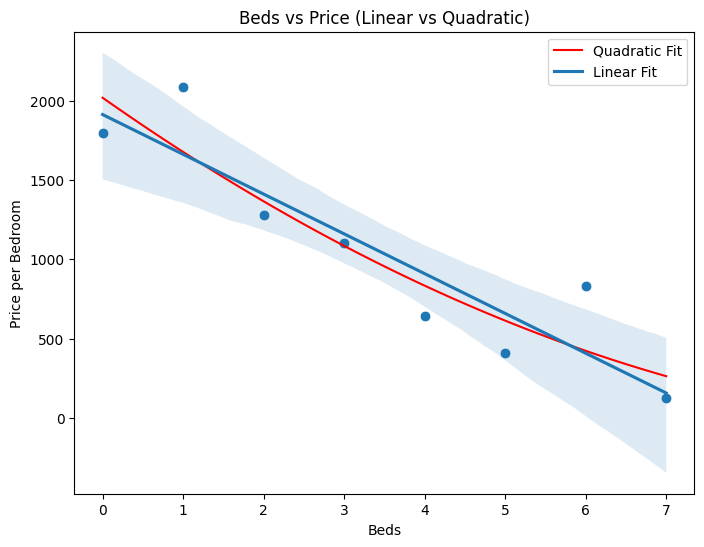

,Model,Line,R²,p-value,Equation,p-values
0,Linear,Rent = -250.60 * Age + 1912.45,0.832563,0.00157,NaN,NaN
1,Quadratic,NaN,0.844693,NaN,Rent = -356.48*Beds + 15.12*Beds^2 + 2018.32,"{'const': 0.0006095746679458775, 'x1': 0.09896..."


In [8]:
import statsmodels.api as sm
# Drop na's and take non-zero price
df_beds = df.dropna(subset=["Bed", "Price"])
df_beds = df_beds[df_beds["Price"] > 0]

# Standardize price
df_beds["Price per Bedroom"] = np.where(df_beds["Bed"] > 0, df_beds["Price"] / df_beds["Bed"], df_beds["Price"])

# Take the average based on the amount of beds
avg_per_bed = df_beds.groupby("Bed")["Price per Bedroom"].mean().reset_index()

# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    avg_per_bed["Bed"], avg_per_bed["Price per Bedroom"]
)

regression_results = {
    "Line": f"Rent = {slope:.2f} * Age + {intercept:.2f}",
    "R²": r_value**2,
    "p-value": p_value
}

X = avg_per_bed["Bed"]
y = avg_per_bed["Price per Bedroom"]

X_poly = np.column_stack((X, X**2))
X_poly = sm.add_constant(X_poly) 
model_poly = sm.OLS(y, X_poly).fit()
print(model_poly.summary())

# Quadratic Regression
regression_results_poly = {
    "Equation": f"Rent = {model_poly.params[1]:.2f}*Beds + {model_poly.params[2]:.2f}*Beds^2 + {model_poly.params[0]:.2f}",
    "R²": model_poly.rsquared,
    "p-values": model_poly.pvalues.to_dict()
}

plt.figure(figsize=(8,6))
sns.scatterplot(x=X, y=y, s=60)

x_range = np.linspace(X.min(), X.max(), 100)
y_pred = model_poly.predict(sm.add_constant(np.column_stack((x_range, x_range**2))))
plt.plot(x_range, y_pred, color="red", label="Quadratic Fit")

sns.regplot(data=avg_per_bed, x="Bed", y="Price per Bedroom", scatter=False, label="Linear Fit")

plt.title("Beds vs Price (Linear vs Quadratic)")
plt.xlabel("Beds")
plt.ylabel("Price per Bedroom")
plt.legend()
plt.show()

results_df = pd.DataFrame([
    {"Model": "Linear", **regression_results},
    {"Model": "Quadratic", **regression_results_poly}
])

display(results_df)


### Bedrooms and Bathrooms

In [9]:
df_beds = df.dropna(subset=["Bed", "Bath", "Price"])
df_beds = df_beds[df_beds["Price"] > 0]

df_beds["Price per Bedroom"] = np.where(
    df_beds["Bed"] > 0,
    df_beds["Price"] / df_beds["Bed"],
    df_beds["Price"]
)

y = df_beds["Price per Bedroom"]
X = df_beds[["Bed", "Bath"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Price per Bedroom   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                 1.969e+04
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        22:01:34   Log-Likelihood:            -8.4843e+05
No. Observations:              110219   AIC:                         1.697e+06
Df Residuals:                  110216   BIC:                         1.697e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2219.9007      4.750    467.392      0.0

In [10]:
# Add squared terms
df_beds["Bed^2"] = df_beds["Bed"]**2
df_beds["Bath^2"] = df_beds["Bath"]**2

X_quad = df_beds[["Bed", "Bath", "Bed^2", "Bath^2"]]
X_quad = sm.add_constant(X_quad)

model_quad = sm.OLS(y, X_quad).fit()
print(model_quad.summary())


                            OLS Regression Results                            
Dep. Variable:      Price per Bedroom   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        22:01:34   Log-Likelihood:            -8.4573e+05
No. Observations:              110219   AIC:                         1.691e+06
Df Residuals:                  110214   BIC:                         1.692e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2472.8978     16.901    146.316      0.0

In [11]:
df_beds["Bed*Bath"] = df_beds["Bed"] * df_beds["Bath"]

X_inter = df_beds[["Bed", "Bath", "Bed*Bath"]]
X_inter = sm.add_constant(X_inter)

model_inter = sm.OLS(y, X_inter).fit()
print(model_inter.summary())


                            OLS Regression Results                            
Dep. Variable:      Price per Bedroom   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                 1.315e+04
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        22:01:34   Log-Likelihood:            -8.4840e+05
No. Observations:              110219   AIC:                         1.697e+06
Df Residuals:                  110215   BIC:                         1.697e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2316.7830     13.787    168.038      0.0

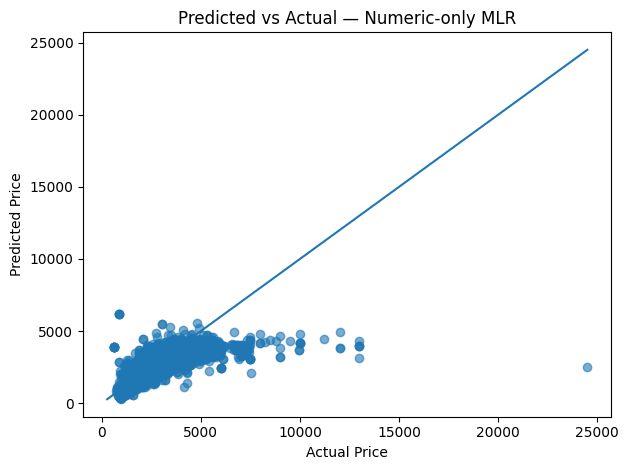

Top 10 features by |coef| (standardized inputs):
5. Latitude: coef=-807.9086, |coef|=807.9086
6. Longitude: coef=-530.3705, |coef|=530.3705
3. SqFt: coef=278.9553, |coef|=278.9553
12. In Unit Laundry: coef=134.6194, |coef|=134.6194
2. Bath: coef=131.3148, |coef|=131.3148
1. Bed: coef=103.3591, |coef|=103.3591
8. Fitness Center: coef=59.2227, |coef|=59.2227
10. Storage: coef=34.5024, |coef|=34.5024
9. Outdoor Space: coef=23.1612, |coef|=23.1612
7. Controlled Access: coef=-17.5176, |coef|=17.5176

Metrics:
                          model  r2_test  rmse_test   mae_test  rows_used  features_used
LinearRegression (numeric-only) 0.568772 555.922036 339.815137     110219             12


In [15]:
# Re-run minimal numeric-only MLR and immediately print top features + save files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_excel("PadmapperData/Padmapper2025.xlsx")

target_col = "Price"
df = df.dropna(subset=[target_col])
df = df[df[target_col] > 0]

candidates = [
    "Bed","Bath","SqFt","Pets",
    "Latitude","Longitude",
    "Controlled Access","Fitness Center","Outdoor Space","Elevator","Storage",
    "EV Charging","Garage Parking","Roof Deck","Concierge","Doorman",
    "On Site Laundry","In Unit Laundry"
]
feature_cols = [c for c in candidates if c in df.columns]

X = df[feature_cols].copy().replace({np.inf: np.nan, -np.inf: np.nan})
y = df[target_col].astype(float)

for c in feature_cols:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
metrics = {
    "model": "LinearRegression (numeric-only)",
    "r2_test": r2_score(y_test, y_pred),
    "rmse_test": root_mean_squared_error(y_test, y_pred),
    "mae_test": mean_absolute_error(y_test, y_pred),
    "rows_used": len(df),
    "features_used": len(feature_cols)
}
metrics_df = pd.DataFrame([metrics])

coef_df = pd.DataFrame({"feature": feature_cols, "coef": lr.coef_})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Plot predicted vs actual
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
miv, mav = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([miv, mav], [miv, mav])
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual — Numeric-only MLR")
plt.tight_layout()
plt.show()

print("Top 10 features by |coef| (standardized inputs):")
for i, row in coef_df.head(10).iterrows():
    print(f"{i+1}. {row['feature']}: coef={row['coef']:.4f}, |coef|={row['abs_coef']:.4f}")

print("\nMetrics:")
print(metrics_df.to_string(index=False))


In [16]:
# --- Cell 1: imports, config, helpers ---
import os, math, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

# ======= CONFIG =======
DATA_PATH = "PadmapperData/Padmapper2025.xlsx"    # change if needed
TARGET    = "Price"
SEED      = 42
TEST_SIZE = 0.20

# speed for permutation importance
PI_MAX_TEST_ROWS = 3000
PI_REPEATS       = 5

# toggles
USE_GEO_SPLINES = True  # set False if your sklearn lacks SplineTransformer

# ======= HELPERS =======
def safe_parse_date(s):
    dt = pd.to_datetime(s, errors="coerce", dayfirst=False)
    if dt.isna().all():
        dt = pd.to_datetime(s, errors="coerce", dayfirst=True)
    return dt

def iqr_bounds(s, k=3.0):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1,lon1,lat2,lon2])
    dlat, dlon = lat2-lat1, lon2-lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

def make_ohe():
    """Version-safe OneHotEncoder (sparse_output in >=1.2, sparse in <1.2)."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def eval_metrics(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mask = y_true > 0
    mape = (np.abs((y_true[mask]-y_pred[mask]) / y_true[mask])).mean()*100 if mask.any() else np.nan
    return {"r2": r2, "rmse": rmse, "mae": mae, "mape_%": mape}


In [17]:
# --- Cell 2: load + basic cleaning ---
assert Path(DATA_PATH).exists(), f"File not found: {DATA_PATH}"
df = pd.read_excel(DATA_PATH).replace({np.inf: np.nan, -np.inf: np.nan}).copy()
assert TARGET in df.columns, f"Target '{TARGET}' not found."

# keep positive target rows only
df = df.dropna(subset=[TARGET])
df = df[df[TARGET] > 0].copy()

# drop obvious leakage / high-cardinality text-ish columns if present
drop_cols = {"Min Price", "Max Price", "Url", "Address", "Building"}
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# parse date if available
if "Date" in df.columns:
    dt = safe_parse_date(df["Date"])
    df["Year"]     = dt.dt.year
    df["Month"]    = dt.dt.month
    df["Quarter"]  = dt.dt.quarter
    df["YearMonth"]= dt.dt.to_period("M").astype(str)
else:
    for c in ["Year","Month","Quarter","YearMonth"]:
        if c not in df.columns: df[c] = np.nan

print("Rows after cleaning:", len(df))


Rows after cleaning: 110219


In [18]:
# --- Cell 3: outliers ---
lo, hi = iqr_bounds(df[TARGET], k=3.0)
df = df[(df[TARGET] >= lo) & (df[TARGET] <= hi)].copy()

if "SqFt" in df.columns:
    q01, q99 = df["SqFt"].quantile([0.01, 0.99])
    df["SqFt"] = df["SqFt"].clip(q01, q99)

print("Rows after outlier trimming:", len(df))


Rows after outlier trimming: 109140


In [19]:
# --- Cell 4: feature engineering ---
# amenity flags (ensure 0/1 ints)
amenity_cols_all = [
    "Controlled Access","Fitness Center","Outdoor Space","Elevator","Storage",
    "EV Charging","Garage Parking","Roof Deck","Concierge","Doorman",
    "On Site Laundry","In Unit Laundry"
]
amenity_cols = [c for c in amenity_cols_all if c in df.columns]
for c in amenity_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int).clip(0,1)

df["amenity_count"] = df[amenity_cols].sum(axis=1) if amenity_cols else 0
premium = [c for c in ["In Unit Laundry","EV Charging","Garage Parking","Roof Deck","Concierge","Doorman"] if c in amenity_cols]
df["premium_amenities"] = df[premium].sum(axis=1) if premium else 0

# interactions
if all(c in df.columns for c in ["SqFt","Bed"]):
    df["SqFt_per_Bed"] = df["SqFt"] / df["Bed"].replace(0, np.nan)
    df["SqFt_x_Bed"]   = df["SqFt"] * df["Bed"]
if all(c in df.columns for c in ["Bed","Bath"]):
    df["Bed_x_Bath"]   = df["Bed"] * df["Bath"]

# lat/lon quantile bins for linear capture of geo
if all(c in df.columns for c in ["Latitude","Longitude"]):
    df["lat_bin"] = pd.qcut(df["Latitude"], q=min(20, df["Latitude"].nunique()), duplicates="drop").astype(str)
    df["lon_bin"] = pd.qcut(df["Longitude"], q=min(20, df["Longitude"].nunique()), duplicates="drop").astype(str)

# city centroid distance (data-driven)
if all(c in df.columns for c in ["City","Latitude","Longitude"]):
    cents = df.groupby("City")[["Latitude","Longitude"]].median().rename(columns={"Latitude":"city_lat","Longitude":"city_lon"})
    df = df.merge(cents, left_on="City", right_index=True, how="left")
    df["dist_to_city_centroid_km"] = haversine_km(df["Latitude"], df["Longitude"], df["city_lat"], df["city_lon"])
else:
    df["dist_to_city_centroid_km"] = np.nan

print("Engineered columns added.")


Engineered columns added.


In [20]:
# --- Cell 5: feature lists + split + optional TE ---
y = df[TARGET].astype(float)
X = df.drop(columns=[TARGET]).copy()

numeric_feats = [c for c in [
    "Bed","Bath","SqFt","Pets","amenity_count","premium_amenities",
    "SqFt_per_Bed","SqFt_x_Bed","Bed_x_Bath",
    "Latitude","Longitude","dist_to_city_centroid_km",
    "Year","Month","Quarter"
] if c in X.columns]

categorical_feats = [c for c in ["City","Listing","lat_bin","lon_bin","YearMonth","Neighbourhood"] if c in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

# Optional: target-encode Neighbourhood if it's very high-cardinality
if "Neighbourhood" in categorical_feats:
    nunique = X_train["Neighbourhood"].nunique(dropna=True)
    if nunique > 50:
        # simple fold-wise TE
        from sklearn.model_selection import KFold
        X_train = X_train.copy(); X_test = X_test.copy()
        X_train["Neighbourhood"] = X_train["Neighbourhood"].astype(str)
        X_test["Neighbourhood"]  = X_test["Neighbourhood"].astype(str)

        global_mean = y_train.mean()
        te = pd.Series(index=X_train.index, dtype=float)
        kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
        for tr, vl in kf.split(X_train):
            means = y_train.iloc[tr].groupby(X_train.iloc[tr]["Neighbourhood"]).mean()
            te.iloc[vl] = X_train.iloc[vl]["Neighbourhood"].map(means).fillna(global_mean).values
        X_train["Neighbourhood_TE"] = te
        X_test["Neighbourhood_TE"]  = X_test["Neighbourhood"].map(y_train.groupby(X_train["Neighbourhood"]).mean()).fillna(global_mean)
        numeric_feats.append("Neighbourhood_TE")
        categorical_feats = [c for c in categorical_feats if c != "Neighbourhood"]

print("numeric_feats:", numeric_feats)
print("categorical_feats:", categorical_feats)
print("Train/Test sizes:", X_train.shape, X_test.shape)


numeric_feats: ['Bed', 'Bath', 'SqFt', 'Pets', 'amenity_count', 'premium_amenities', 'SqFt_per_Bed', 'SqFt_x_Bed', 'Bed_x_Bath', 'Latitude', 'Longitude', 'dist_to_city_centroid_km', 'Year', 'Month', 'Quarter', 'Neighbourhood_TE']
categorical_feats: ['City', 'Listing', 'lat_bin', 'lon_bin', 'YearMonth']
Train/Test sizes: (87312, 38) (21828, 38)


In [21]:
# --- Cell 6: preprocessing pipeline ---
# numeric
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# categorical: impute -> cast to str -> OHE
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("to_str", FunctionTransformer(lambda X: X.astype(str))),
    ("ohe", make_ohe())
])

transformers = []
if numeric_feats:
    transformers.append(("num", numeric_transformer, numeric_feats))
if categorical_feats:
    transformers.append(("cat", categorical_transformer, categorical_feats))

# optional: spline smoother for lat/lon
if USE_GEO_SPLINES and all(c in X_train.columns for c in ["Latitude","Longitude"]):
    try:
        from sklearn.preprocessing import SplineTransformer
        geo_splines = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("spl", SplineTransformer(degree=3, n_knots=5, include_bias=False)),
            ("scaler", StandardScaler())
        ])
        transformers.append(("geo_splines", geo_splines, ["Latitude","Longitude"]))
        print("Geo splines enabled.")
    except Exception as e:
        print("Geo splines disabled (skipped):", e)

preprocess = ColumnTransformer(transformers=transformers, remainder="drop")
print("Preprocess ready.")


Geo splines enabled.
Preprocess ready.


In [22]:
# --- Cell 7: models dict ---
alphas_ridge = np.logspace(-3, 3, 30)
alphas_lasso = np.logspace(-3, 1, 30)

models = {
    "OLS": Pipeline([("preprocess", preprocess), ("model", LinearRegression())]),
    "RidgeCV": Pipeline([("preprocess", preprocess), ("model", RidgeCV(alphas=alphas_ridge))]),
    "LassoCV": Pipeline([("preprocess", preprocess), ("model", LassoCV(alphas=alphas_lasso, max_iter=5000, cv=5))]),
    "RidgeCV_logPrice": Pipeline([
        ("preprocess", preprocess),
        ("model", TransformedTargetRegressor(regressor=RidgeCV(alphas=alphas_ridge), func=np.log1p, inverse_func=np.expm1))
    ]),
    "LassoCV_logPrice": Pipeline([
        ("preprocess", preprocess),
        ("model", TransformedTargetRegressor(regressor=LassoCV(alphas=alphas_lasso, max_iter=5000, cv=5), func=np.log1p, inverse_func=np.expm1))
    ])
}
print("Models ready:", list(models.keys()))


Models ready: ['OLS', 'RidgeCV', 'LassoCV', 'RidgeCV_logPrice', 'LassoCV_logPrice']


In [ ]:
# --- Cell 8: fit & evaluate ---
def evaluate_pipeline(name, pipe, X_tr, X_te, y_tr, y_te):
    t0 = time.time()
    pipe.fit(X_tr, y_tr)
    fit_s = time.time() - t0
    yhat_tr = pipe.predict(X_tr)
    yhat_te = pipe.predict(X_te)
    m_tr = eval_metrics(y_tr, yhat_tr)
    m_te = eval_metrics(y_te, yhat_te)
    return {
        "model": name,
        "fit_secs": round(fit_s, 2),
        "train_r2": m_tr["r2"], "train_rmse": m_tr["rmse"], "train_mae": m_tr["mae"], "train_mape_%": m_tr["mape_%"],
        "test_r2":  m_te["r2"], "test_rmse":  m_te["rmse"], "test_mae":  m_te["mae"], "test_mape_%":  m_te["mape_%"],
        "fitted": pipe
    }

results = []
for name, pipe in models.items():
    try:
        results.append(evaluate_pipeline(name, pipe, X_train, X_test, y_train, y_test))
    except Exception as e:
        results.append({"model": name, "error": str(e)})

metrics_df = pd.DataFrame([{k:v for k,v in r.items() if k!="fitted"} for r in results])
display(metrics_df)

if "test_r2" not in metrics_df.columns:
    display(pd.DataFrame(results))
    raise RuntimeError("All models failed to fit. See 'error' column above.")

metrics_sorted = metrics_df.sort_values("test_r2", ascending=False, na_position="last").reset_index(drop=True)
display(metrics_sorted)

valid = [r for r in results if "fitted" in r]
best = max(valid, key=lambda d: d.get("test_r2", float("-inf")))
best_name, best_pipe = best["model"], best["fitted"]
print("Best model:", best_name)


In [ ]:
# --- Cell 9: coefficients & save ---
def get_feature_names(fitted_preprocess):
    names = []
    for name, trans, cols in fitted_preprocess.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps"):
            last = list(trans.named_steps.values())[-1]
            if hasattr(last, "get_feature_names_out"):
                try:
                    names += list(last.get_feature_names_out(cols))
                    continue
                except Exception:
                    pass
        names += list(cols) if isinstance(cols, (list, tuple, pd.Index, np.ndarray)) else [cols]
    return names

feature_names = get_feature_names(best_pipe.named_steps["preprocess"])

coef_table = None
model = best_pipe.named_steps["model"]
if isinstance(model, TransformedTargetRegressor):
    model = model.regressor_
coefs = getattr(model, "coef_", None)

if coefs is not None:
    coef_table = pd.DataFrame({"feature": feature_names[:len(coefs)], "coef": coefs})
    coef_table["abs_coef"] = coef_table["coef"].abs()
    coef_table = coef_table.sort_values("abs_coef", ascending=False)
    display(coef_table.head(30))
    coef_table.to_csv("feature_importance_coefficients.csv", index=False)
    print("Saved: feature_importance_coefficients.csv")
else:
    print("This best model doesn't expose linear coefficients.")


In [ ]:
# --- Cell 10: permutation importance ---
from sklearn.inspection import permutation_importance

# sample test set for speed
if len(X_test) > PI_MAX_TEST_ROWS:
    Xs = X_test.sample(PI_MAX_TEST_ROWS, random_state=SEED)
    ys = y_test.loc[Xs.index]
else:
    Xs, ys = X_test, y_test

try:
    pi = permutation_importance(best_pipe, Xs, ys, n_repeats=PI_REPEATS, random_state=SEED, scoring="r2")
    pi_df = pd.DataFrame({
        "feature": feature_names[:len(pi.importances_mean)],
        "importance_mean": pi.importances_mean,
        "importance_std": pi.importances_std
    }).sort_values("importance_mean", ascending=False)
    display(pi_df.head(30))
    pi_df.to_csv("feature_importance_permutation.csv", index=False)
    print("Saved: feature_importance_permutation.csv")
except Exception as e:
    print("Permutation importance skipped:", e)


In [ ]:
# --- Cell 11: VIF on numeric core ---
def compute_vif(X_df):
    from sklearn.linear_model import LinearRegression
    out = []
    cols = X_df.columns.tolist()
    for c in cols:
        y = X_df[c].values
        X = X_df.drop(columns=[c]).values
        lr = LinearRegression()
        lr.fit(X, y)
        r2 = lr.score(X, y)
        vif = np.inf if (1 - r2) <= 1e-8 else 1.0/(1.0 - r2)
        out.append({"feature": c, "VIF": vif})
    return pd.DataFrame(out).sort_values("VIF", ascending=False)

numeric_only = [c for c in ["Bed","Bath","SqFt","Pets","amenity_count","premium_amenities",
                            "SqFt_per_Bed","SqFt_x_Bed","Bed_x_Bath",
                            "Latitude","Longitude","dist_to_city_centroid_km",
                            "Year","Month","Quarter","Neighbourhood_TE"] if c in X_train.columns]
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
X_num = pd.DataFrame(num_pipe.fit_transform(X_train[numeric_only]), columns=numeric_only, index=X_train.index)

vif_df = compute_vif(X_num)
display(vif_df.head(30))
vif_df.to_csv("vif_numeric_core.csv", index=False)
print("Saved: vif_numeric_core.csv")


In [ ]:
# --- Cell 12: diagnostics plots ---
yhat = best_pipe.predict(X_test)
mn, mx = min(y_test.min(), yhat.min()), max(y_test.max(), yhat.max())

plt.figure(figsize=(6,5))
plt.scatter(y_test, yhat, alpha=0.5)
plt.plot([mn, mx],[mn, mx])
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual — {best_name}")
plt.tight_layout(); plt.savefig("pred_vs_actual.png", dpi=160); plt.show()

resid = y_test - yhat
plt.figure(figsize=(6,5))
plt.scatter(yhat, resid, alpha=0.5)
plt.axhline(0, lw=1)
plt.xlabel("Predicted"); plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout(); plt.savefig("residuals.png", dpi=160); plt.show()

if "City" in X_test.columns:
    err_by_city = pd.DataFrame({"City": X_test["City"], "abs_err": (y_test - yhat).abs()}) \
                    .groupby("City", as_index=False)["abs_err"].mean() \
                    .sort_values("abs_err")
    display(err_by_city.head(15))

print("Saved: pred_vs_actual.png, residuals.png")
